In [1]:
import os
import torch
import matplotlib.pylab as plt
import numpy as np
import traceback
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
import torchnet.meter.confusionmeter as cm
import seaborn as sns
from os import walk
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os
from PIL import Image
import numpy as np

from __future__ import print_function, division

torch.manual_seed(0)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import plotly.express as px

cudnn.benchmark = True
plt.ion()  # interactive mode

C:\Users\vnarv\anaconda3\envs\venv_test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# folder path
# dir_path = "C://Users//vnarv//PycharmProjects/pytorch_example/data/garbage_classification/"
dir_path = "C://Users//vnarv//PycharmProjects/pytorch_classification/data/garbage_classification"

In [3]:
os.chdir("C://Users//vnarv//PycharmProjects/pytorch_classification")

## Comptage images 

In [4]:
def _build_paths(dataset, main_path=dir_path):
    # list to store files name
    res = []
    df = pd.DataFrame()
    for _, dir_names, file_names in walk(os.path.join(main_path, dataset)):
        res.extend(file_names)

    df = pd.DataFrame({"filename": res})
    df["material"] = df["filename"].str.split("_").str[0]
    df["set"] = dataset
    df["filepath"] = (
        main_path + "/" + dataset + "/" + df["material"] + "/" + df["filename"]
    )
    return df

In [5]:
df_img_paths = pd.concat([_build_paths("train"), _build_paths("test")], axis=0)
df_img_paths = df_img_paths.reset_index(drop=True)
df_img_paths.loc[df_img_paths["material"] == "Metal", "material"] = "Métal"
df_img_paths.loc[df_img_paths["material"] == "Plastico", "material"] = "Plastique"
df_img_paths.loc[df_img_paths["material"] == "Vidrio", "material"] = "Verre"

In [45]:
df_img_paths.head()

filename material    set  \
0   Carton_10.jpg   Carton  train   
1  Carton_100.jpg   Carton  train   
2  Carton_101.jpg   Carton  train   
3  Carton_102.jpg   Carton  train   
4  Carton_103.jpg   Carton  train   

                                            filepath  
0  C://Users//vnarv//PycharmProjects/pytorch_clas...  
1  C://Users//vnarv//PycharmProjects/pytorch_clas...  
2  C://Users//vnarv//PycharmProjects/pytorch_clas...  
3  C://Users//vnarv//PycharmProjects/pytorch_clas...  
4  C://Users//vnarv//PycharmProjects/pytorch_clas...

In [6]:
cmp_all_img = (
    df_img_paths.groupby(["material", "set"])["filename"].nunique().reset_index()
)

In [7]:
cmp_all_img

material    set  filename
0     Carton   test        96
1     Carton  train       265
2      Métal   test        96
3      Métal  train       356
4  Plastique   test        96
5  Plastique  train       518
6      Verre   test        96
7      Verre  train       398

In [8]:
fig = px.histogram(
    cmp_all_img,
    x="material",
    y="filename",
    color="set",
    color_discrete_sequence=px.colors.qualitative.Dark24,
    template="simple_white",
    title="Répartition des images",
)
fig.update_layout(
    xaxis_title="Matériaux",
    yaxis_title="Nb images",
    plot_bgcolor="rgba(255,255,255)",
    paper_bgcolor="rgba(255,255,255)",
)
fig.update_traces(marker_line_color="black", marker_line_width=2)
fig.show()

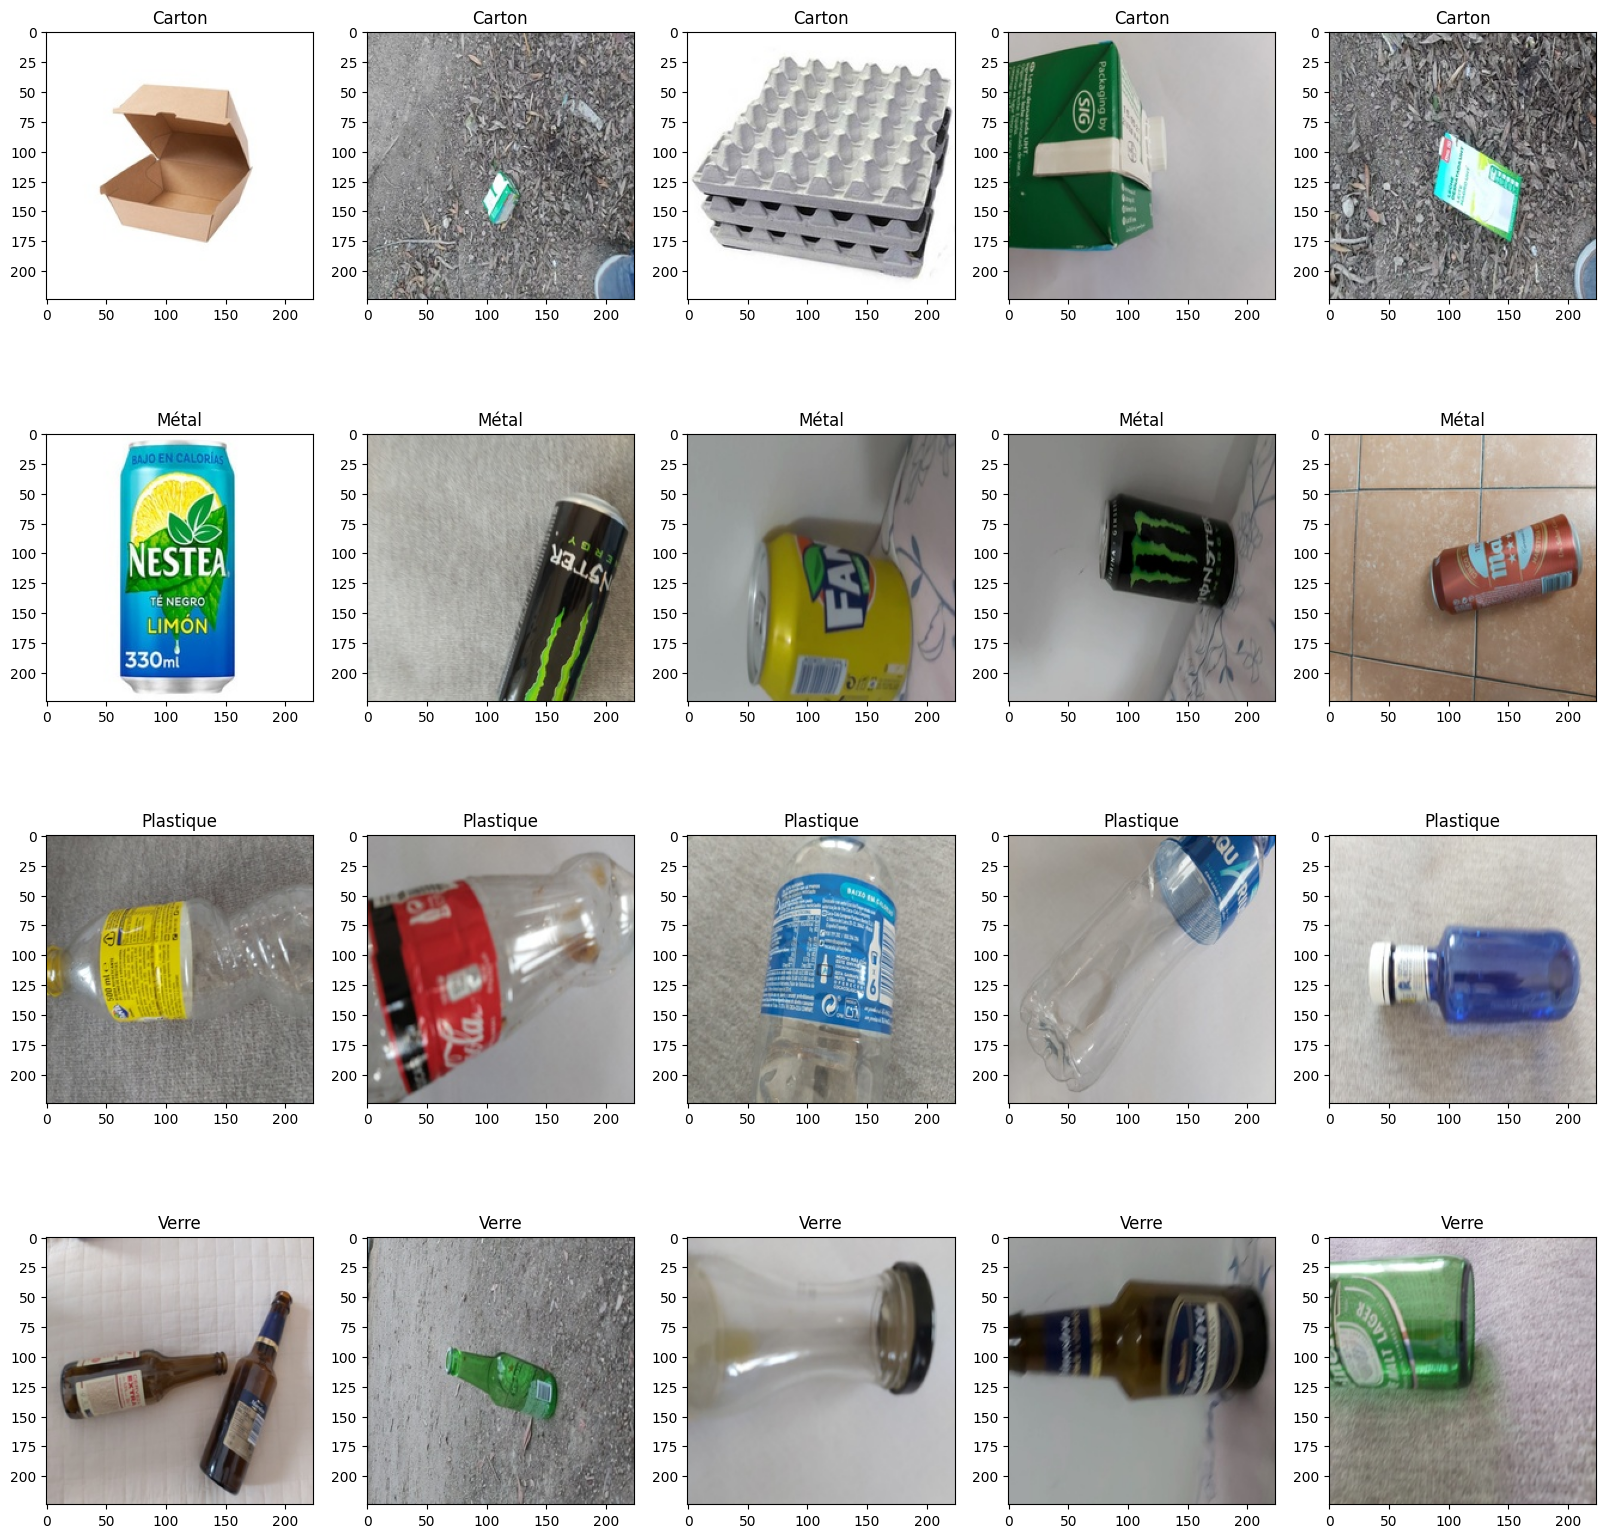

In [49]:
df_img_paths["seq"] = df_img_paths.groupby(["material"]).cumcount()
sample = df_img_paths[df_img_paths["seq"] < 5].reset_index(drop=True)
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.title("%s" % (sample["material"][i]))
    image = Image.open(sample["filepath"][i])
    plt.imshow(image)

## Image size

height is 224 width is 224


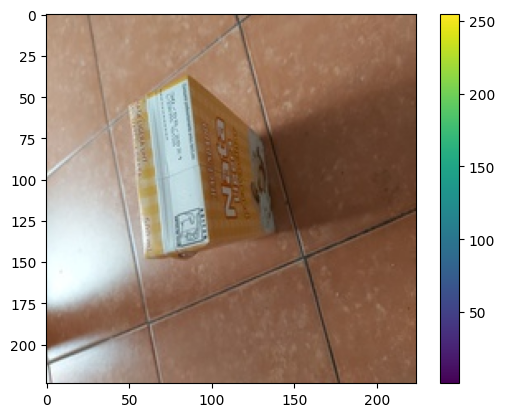

In [52]:
image_path = df_img_paths["filepath"][10]
image = Image.open(image_path)
plt.imshow(image)
plt.colorbar()
# Read the height and width of the image
height, width, shape = np.asarray(image).shape
print(f"height is {height}", f"width is {width}")

# print(f"The dimensions of the image are {image.shape[0]} pixels width and {image.shape[1]} pixels height, one single color channel")
# print(f"The maximum pixel value is {image.max():.4f} and the minimum is {image.min():.4f}")
# print(f"The mean value of the pixels is {image.mean():.4f} and the standard deviation is {image.std():.4f}")

In [54]:
data_transforms = {
    "train": transforms.Compose([transforms.ToTensor()]),
    "test": transforms.Compose([transforms.ToTensor()]),
}


data_dir = "data/garbage_classification"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "test"]
}
test_sizes_loader = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=1, shuffle=False, num_workers=1
    )
    for x in ["train", "test"]
}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "test"]}
print(f"nb of images on each set : {dataset_sizes}")

nb of images on each set : {'train': 1537, 'test': 384}


In [55]:
train_shape = []
for images, labels in test_sizes_loader["train"]:
    train_shape.append(images.shape)
print(f"Image size on the train set : {set(train_shape)}")

Image size on the train set : {torch.Size([1, 3, 224, 224])}


In [56]:
val_shape = []
for images, labels in test_sizes_loader["test"]:
    val_shape.append(images.shape)
print(f"Image size on the test set : {set(val_shape)}")

Image size on the test set : {torch.Size([1, 3, 224, 224])}


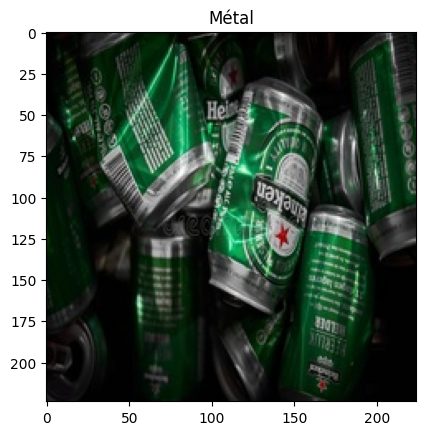

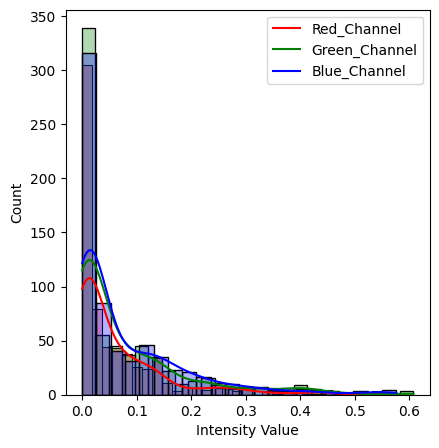

In [90]:
img = Image.open(df_img_paths["filepath"][321])
convert_tensor = transforms.ToTensor()
img_tensor = convert_tensor(img)
plt.imshow(img)
plt.title(f"{df_img_paths['material'][321]}")
plt.show()


plt.figure(figsize=(4.7, 5))
# plot the histogram
# _ = sns.histplot(img_tensor.ravel(), color='Grey', kde=True,  alpha=0.3)
_ = sns.histplot(img_tensor[:, 0].ravel(), color="Red", kde=True, alpha=0.3)
_ = sns.histplot(img_tensor[:, 1].ravel(), color="Green", kde=True, alpha=0.3)
_ = sns.histplot(img_tensor[:, 2].ravel(), color="Blue", kde=True, alpha=0.3)
_ = plt.xlabel("Intensity Value")
_ = plt.ylabel("Count")
_ = plt.legend(["Red_Channel", "Green_Channel", "Blue_Channel"])
# plt.hist(inputs.ravel(), bins=256, range=(0, 1), fc='k', ec='k')
plt.show()

## Descriptive statistics

In [60]:
data_transforms = {
    "train": transforms.Compose([transforms.ToTensor()]),
    "test": transforms.Compose([transforms.ToTensor()]),
}

data_dir = "data/garbage_classification"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "test"]
}
data_loader = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=1, shuffle=False, num_workers=1
    )
    for x in ["train", "test"]
}

In [61]:
mean_batch = []
std_batch = []
for img, label in data_loader["train"]:
    mean_batch.append(torch.mean(img).item())
    std_batch.append(torch.std(img).item())

In [62]:
# compute gloval mean and std on the train set
mean = 0.0
std = 0.0
nb_samples = 0.0
for data, _ in data_loader["train"]:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [63]:
print(f"mean {mean} and {std}")

mean tensor([0.5783, 0.5548, 0.5275]) and tensor([0.1638, 0.1576, 0.1710])


Text(0, 0.5, 'Pixel mean')

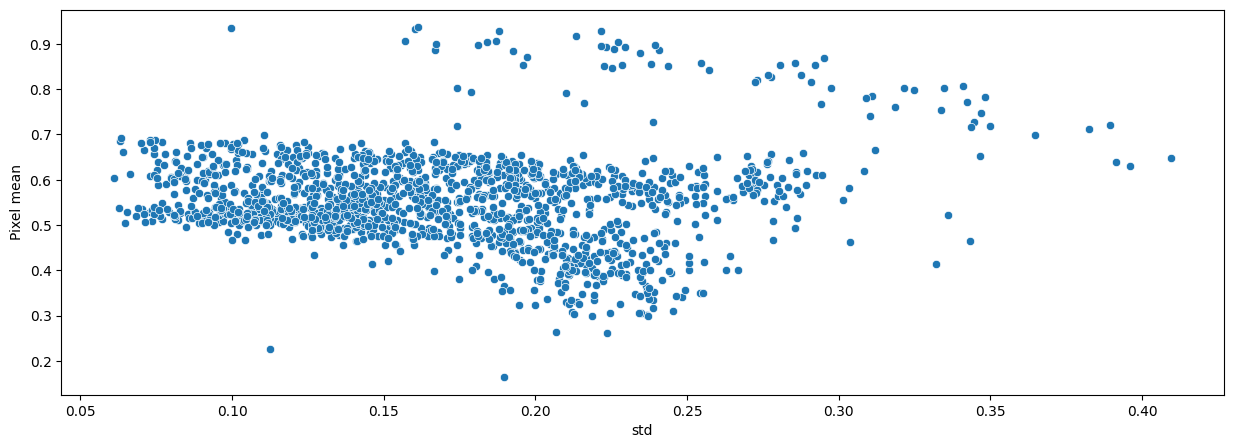

In [64]:
plt.figure(figsize=(15, 5))
values = [mean_batch, std_batch]
sns.scatterplot(x=std_batch, y=mean_batch)
plt.title("")
plt.xlabel("std")
plt.ylabel("Pixel mean")

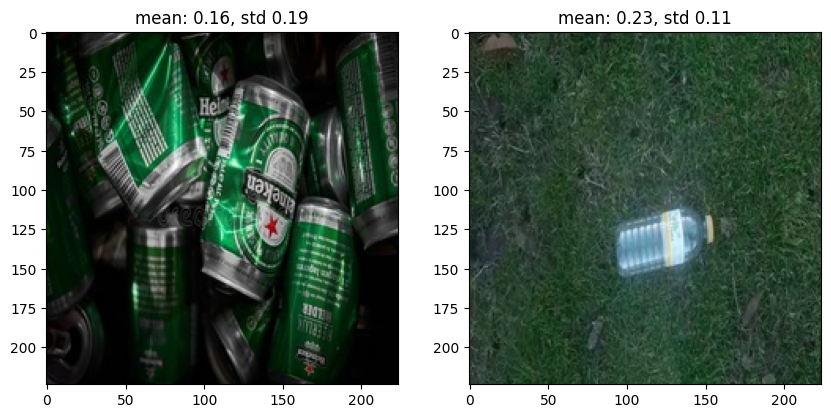

In [65]:
image_999 = df_img_paths["filepath"][999]
image_321 = df_img_paths["filepath"][321]
convert_tensor = transforms.ToTensor()

plt.figure(figsize=(10, 5))
for i, img in enumerate([image_321, image_999]):
    plt.subplot(1, 2, i + 1)
    image = Image.open(img)
    plt.imshow(image)
    img_tensor = convert_tensor(image)
    tmp_mean = torch.mean(img_tensor).item()
    tmp_std = torch.std(img_tensor).item()
    plt.title("mean: %.2f, std %.2f" % (tmp_mean, tmp_std))

In [86]:
# we use a batch size of 100 to ensure that the statistics are representative of the entire dataset
data_loader = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=1, shuffle=False, num_workers=1
    )
    for x in ["train", "test"]
}


mean_batch = []
mean_R = []
mean_G = []
mean_B = []
std_batch = []
std_batch_R = []
std_batch_G = []
std_batch_B = []
for img, label in data_loader["train"]:
    # Calculate the mean, standard deviation, min, and max of the pixel values
    # Get the mean of the R channel
    mean_R.append(torch.mean(img[:, 0]).item())
    # Get the mean of the G channel
    mean_G.append(torch.mean(img[:, 1]).item())
    # Get the mean of the B channel
    mean_B.append(torch.mean(img[:, 2]).item())
    mean_batch.append(torch.mean(img).item())
    std_batch.append(torch.std(img).item())
    std_batch_R.append(torch.std(img[:, 0]).item())
    std_batch_G.append(torch.std(img[:, 1]).item())
    std_batch_B.append(torch.std(img[:, 2]).item())

[Text(0.5, 0, 'Ecart-type'), Text(0, 0.5, 'moyenne'), (0.0, 0.5), (0.0, 1.0)]

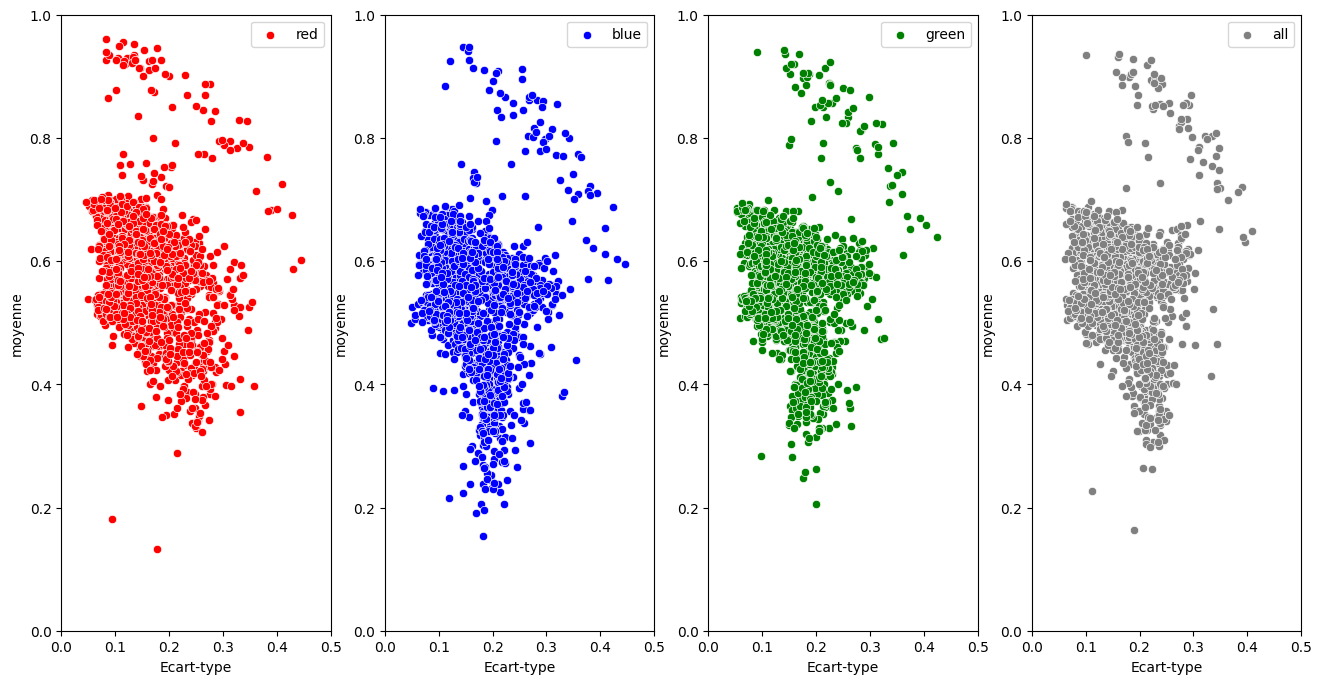

In [80]:
fig, axes = plt.subplots(1, 4, sharex=True, figsize=(16, 8))
sns.scatterplot(ax=axes[0], x=std_batch_R, y=mean_R, color="red", label="red")
axes[0].set(xlabel="Ecart-type", ylabel="moyenne", xlim=(0, 0.5), ylim=(0, 1))
sns.scatterplot(
    ax=axes[1],
    x=std_batch_B,
    y=mean_B,
    color="blue",
    label="blue",
)
axes[1].set(xlabel="Ecart-type", ylabel="moyenne", xlim=(0, 0.5), ylim=(0, 1))
sns.scatterplot(ax=axes[2], x=std_batch_G, y=mean_G, color="green", label="green")
axes[2].set(xlabel="Ecart-type", ylabel="moyenne", xlim=(0, 0.5), ylim=(0, 1))
sns.scatterplot(ax=axes[3], x=std_batch, y=mean_batch, color="grey", label="all")
axes[3].set(xlabel="Ecart-type", ylabel="moyenne", xlim=(0, 0.5), ylim=(0, 1))

In [85]:
df_red = pd.DataFrame()
df_red["red"] = mean_R
df_red["std_red"] = std_batch_R
df_red.sort_values("red")

red   std_red
321   0.132741  0.177492
999   0.181564  0.093816
886   0.288147  0.215266
583   0.322692  0.261072
249   0.329301  0.249553
...        ...       ...
1532  0.946192  0.177929
330   0.948977  0.107202
211   0.952474  0.135360
238   0.954967  0.114605
243   0.960863  0.082069

[1537 rows x 2 columns]

In [95]:
df_blue.sort_values(["std_blue", "blue"]).head(20)

blue  std_blue
33    0.500291  0.049405
116   0.525209  0.049744
132   0.505990  0.056177
231   0.512455  0.056695
1034  0.578188  0.060851
142   0.530739  0.062380
778   0.594544  0.063270
853   0.593433  0.063475
957   0.609478  0.063703
1194  0.678023  0.064464
1195  0.684587  0.065622
837   0.595100  0.065676
955   0.640218  0.067348
844   0.678968  0.067730
918   0.609490  0.067875
1531  0.536377  0.068006
1431  0.516251  0.068387
725   0.532842  0.068725
161   0.501648  0.068754
830   0.603713  0.070106

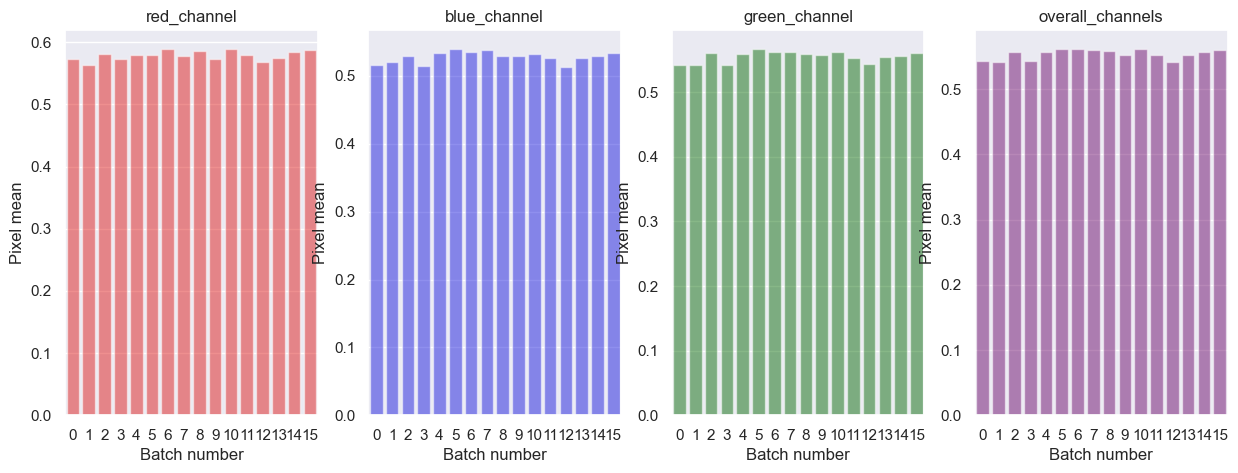

In [78]:
plt.figure(figsize=(15, 5))
colors_mean = ["red", "blue", "green", "purple"]
mean_values = [mean_R, mean_B, mean_G, mean_batch]
label_values = ["red_channel", "blue_channel", "green_channel", "overall_channels"]
batch_nb = len(mean_R)
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title("%s" % (label_values[i]))
    sns.barplot(
        x=[i for i in range(batch_nb)],
        y=mean_values[i],
        color=colors_mean[i],
        alpha=0.5,
    )
    plt.xlabel("Batch number")
    plt.ylabel("Pixel mean")

# plt.title('Mean pixel values across batches (train set)')

# prochaine etape: faire un graphique avec la deviation std et la moyenne et interpreter

### Horizontal flip and random flip

In [65]:
df_img_paths[df_img_paths["filename"] == "Vidrio_160.jpg"]

filename material    set  \
1196  Vidrio_160.jpg   Vidrio  train   

                                               filepath  seq  
1196  C://Users//vnarv//PycharmProjects/pytorch_exam...   57

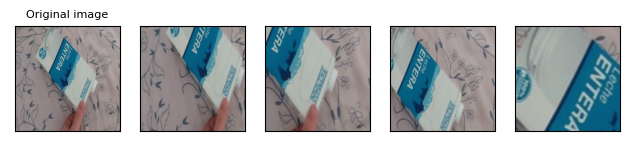

In [88]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = "tight"
# orig_img = Image.open(Path('assets') / 'astronaut.jpg')
orig_img = Image.open(df_img_paths["filepath"][20])
# if you change the seed, make sure that the randomly-applied transforms
# properly show that the image can be both transformed and *not* transformed!
torch.manual_seed(0)


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title="Original image")
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            print(row_title[row_idx])
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()


hflipper = T.RandomResizedCrop(224)
# for img, label in data_loader["train"]:
transformed_imgs = [hflipper(orig_img) for _ in range(4)]
plot(transformed_imgs)